In [37]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import umap

import hdbscan
import matplotlib.pyplot as plt

import pandas as pd

from bertopic import BERTopic
from top2vec import Top2Vec
from sklearn.datasets import fetch_20newsgroups

### Load Sate of the art libraries for NLP, clustering and topic modeling

In [39]:
sentence_bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
topic_model = BERTopic()

### Load a pre-existing dataset using datasets library

In [18]:
dataset = load_dataset("McGill-NLP/TopiOCQA")
questions = dataset['validation']['Question']
topics = dataset['validation']['Topic']

print(len(questions), len(topics))
print(questions[:5])
print(topics[:5])

Reusing dataset topi_ocqa (/home/chandra/.cache/huggingface/datasets/McGill-NLP___topi_ocqa/plain_text/1.0.0/8c589d13ad128c68a8e55d042b41d312d2accc9503b35aa31d4a47319bf4c023)
100%|██████████| 2/2 [00:00<00:00, 173.44it/s]

2514 2514
['what is the boy scout order of the arrow', 'when was this honor society established?', 'who established it?', 'what is the profession of this first person mentioned?', 'what were some of his recognitions?']
['Order of the Arrow', 'Order of the Arrow', 'Order of the Arrow', 'E. Urner Goodman', 'E. Urner Goodman']


### For the data load sentence embeddings i.e. representations of the data using SSL based pre-trained model 

In [22]:

embeddings = sentence_bert_model.encode(questions, show_progress_bar=True)

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)


Batches: 100%|██████████| 79/79 [00:00<00:00, 131.97it/s]


### Cluster the data based on their representations obtained from SSL based pre-trained model 

In [24]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

### Plot the clusters based on their representations

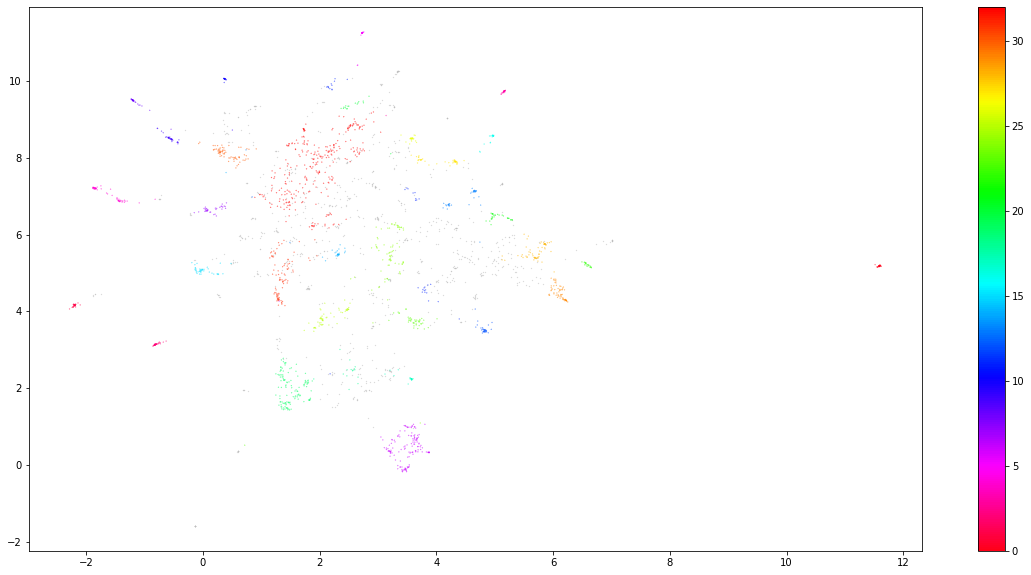

In [26]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### Extract key topics from the data using an SSL based pre-trained model

In [41]:
#topics, probs = topic_model.fit_transform(questions)
topic_model = Top2Vec(questions, workers=8)

2022-04-19 02:11:29,869 - top2vec - INFO - Pre-processing documents for training
2022-04-19 02:11:29,912 - top2vec - INFO - Creating joint document/word embedding
2022-04-19 02:11:32,635 - top2vec - INFO - Creating lower dimension embedding of documents
2022-04-19 02:11:38,967 - top2vec - INFO - Finding dense areas of documents
2022-04-19 02:11:39,067 - top2vec - INFO - Finding topics


In [42]:
topic_model.get_num_topics()

9

In [47]:
topic_words, word_scores, topic_nums = topic_model.get_topics(1)
topic_words, word_scores, topic_nums

(array([['did', 'located', 'is', 'other', 'on', 'its', 'how', 'there',
         'his', 'she', 'name', 'of', 'has', 'by', 'was', 'some', 'the',
         'and', 'they', 'were', 'above', 'one', 'when', 'are',
         'mentioned', 'from', 'with', 'can', 'this', 'do', 'who', 'place',
         'film', 'about', 'for', 'it', 'where', 'first', 'have', 'does',
         'you', 'any', 'what', 'which', 'that', 'he', 'to', 'in']],
       dtype='<U9'),
 array([[ 0.12446086,  0.10781362,  0.09551541,  0.09534524,  0.06965357,
          0.06404963,  0.05841708,  0.05616149,  0.05193724,  0.05046318,
          0.04935917,  0.04603643,  0.04586108,  0.04260824,  0.03712722,
          0.03466802,  0.03404956,  0.02650846,  0.02471298,  0.02451361,
          0.02031521,  0.01603961,  0.01368193,  0.00958306,  0.00603249,
          0.0004958 , -0.0019475 , -0.00632669, -0.00850062, -0.01136921,
         -0.01759024, -0.02062498, -0.02189101, -0.02208793, -0.02520685,
         -0.02824923, -0.02964318, -0.0

### Plot the wordcloud of the discovered topics

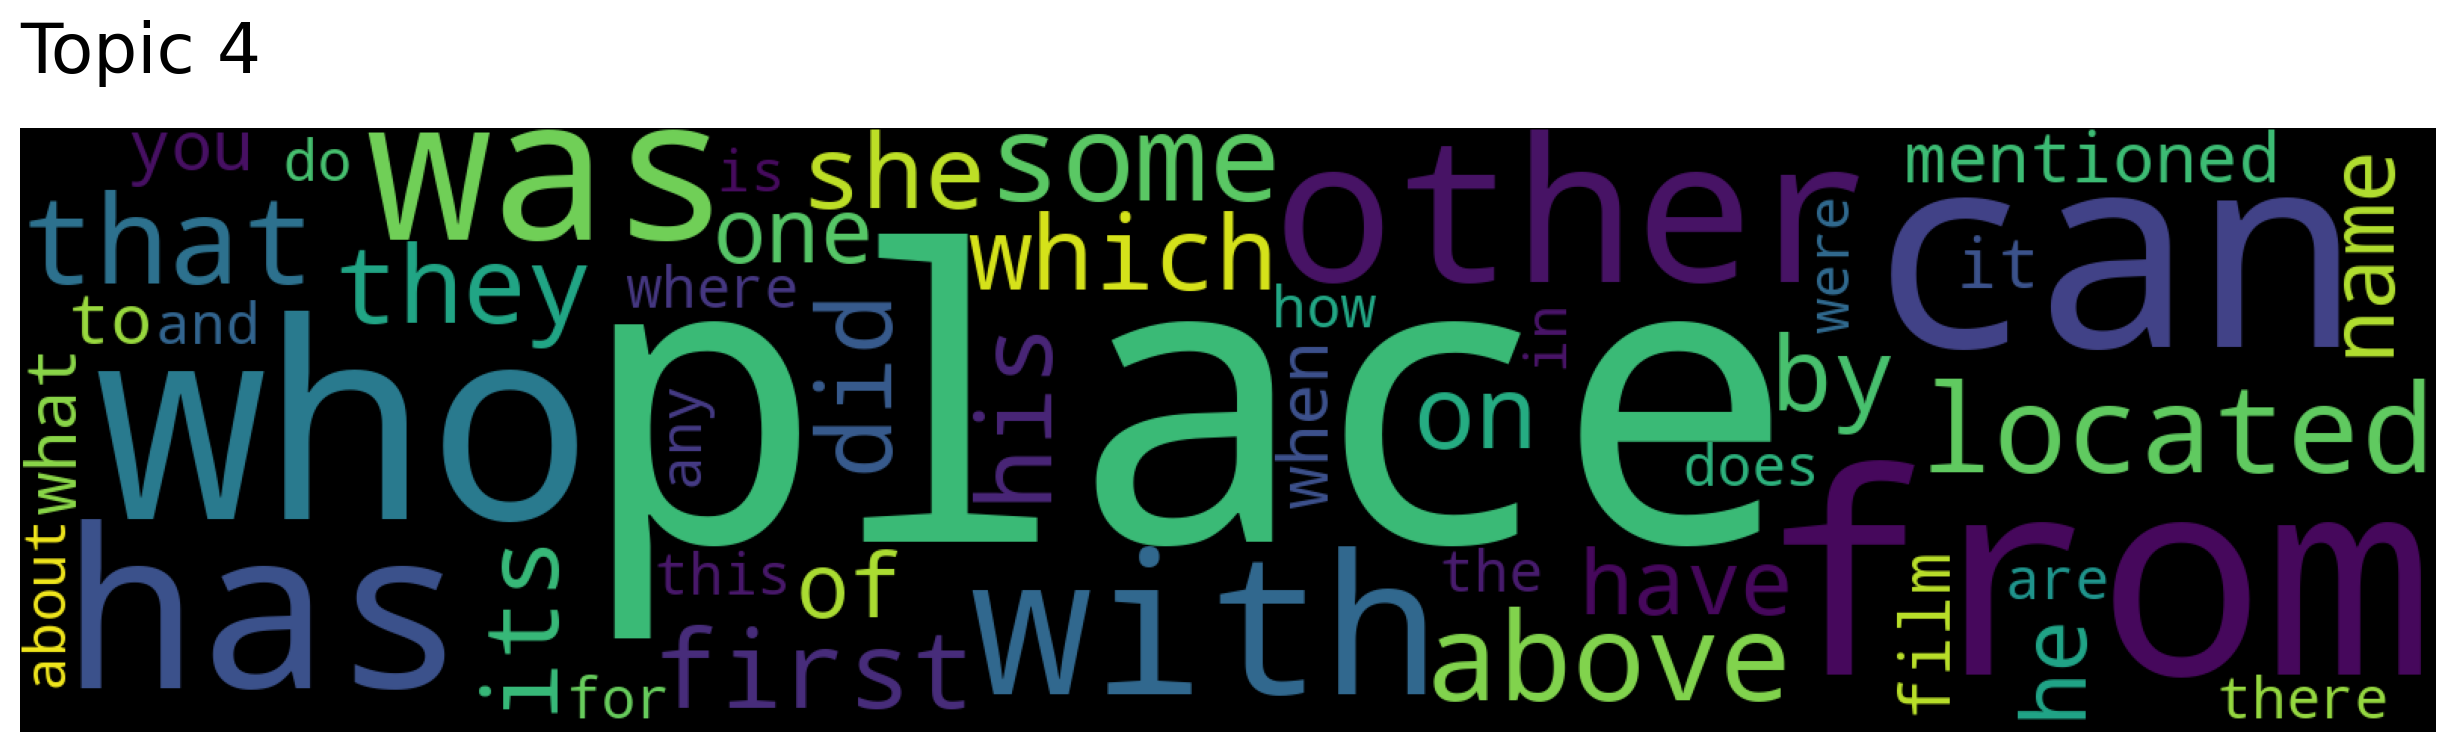

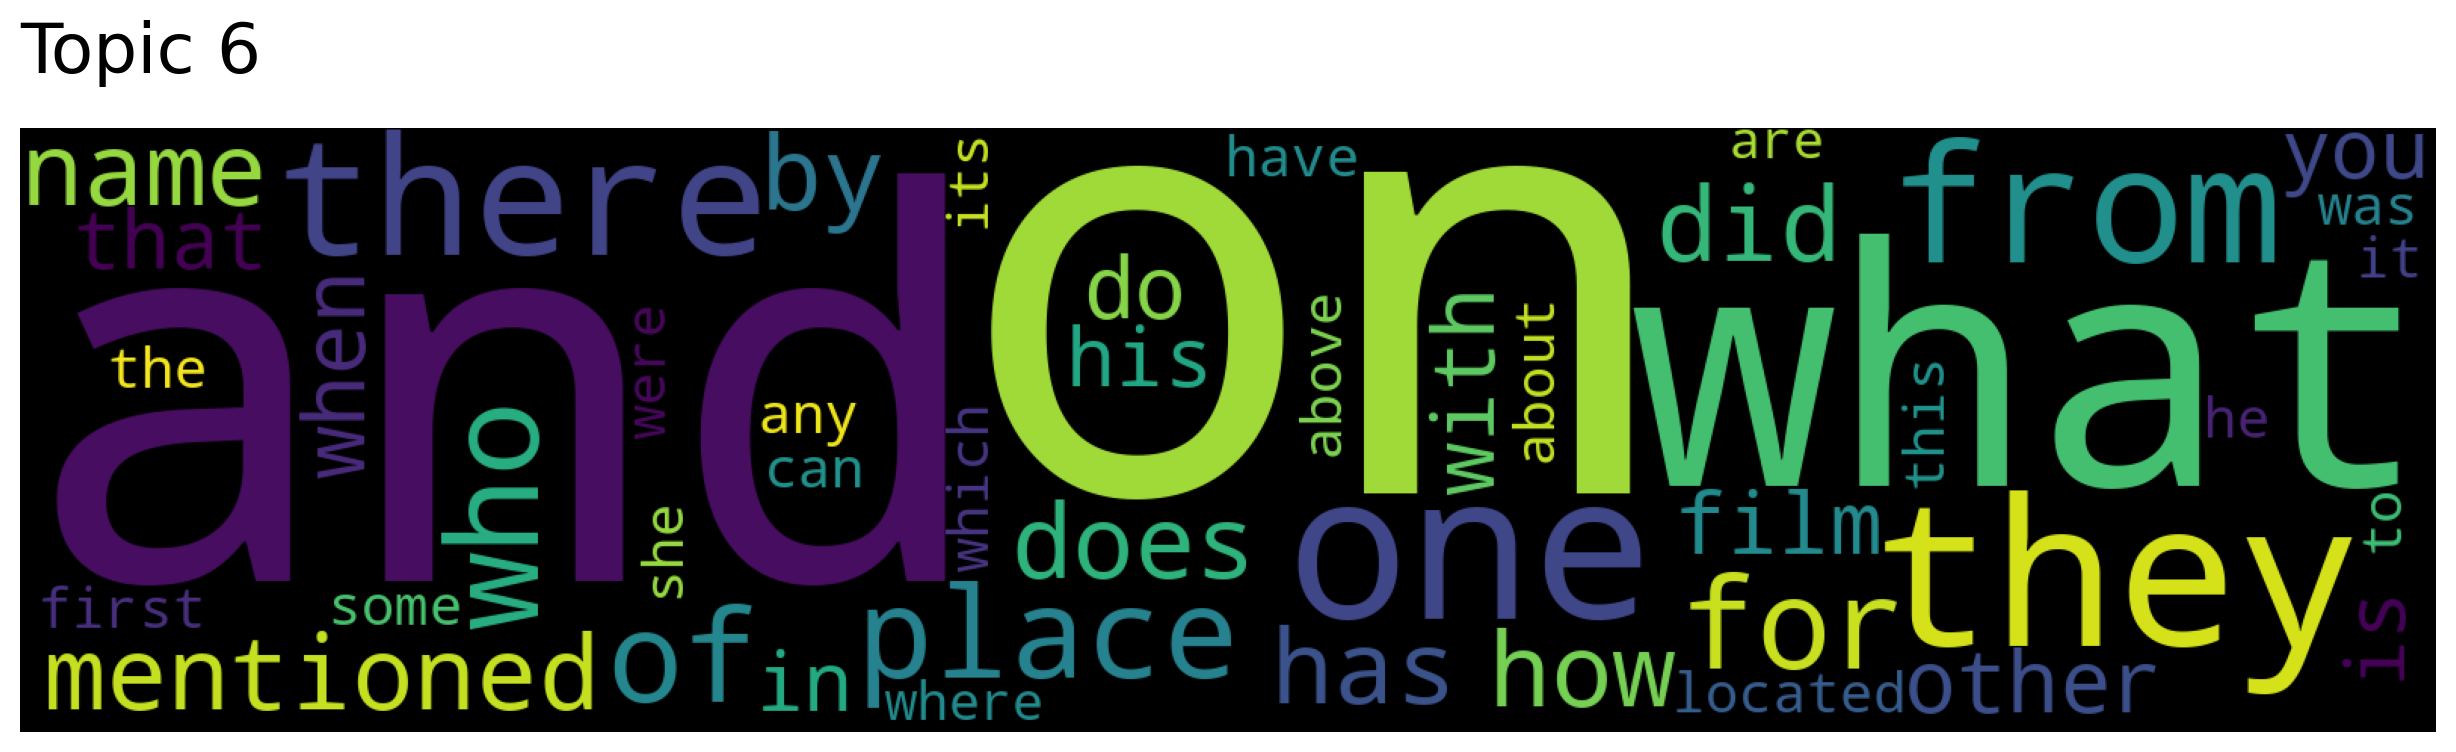

In [53]:
topic_words, word_scores, topic_scores, topic_nums = topic_model.search_topics(keywords=["place"], num_topics=2)
for topic in topic_nums:
    topic_model.generate_topic_wordcloud(topic)